# Predictive Policing in San Francisco (SF)

## Table of Contents

- [Setup](#setup)
- [Process 2016 Data](#process-2016-data)
- [Process 2017 Data](#process-2017-data)
- [Test Models](#test-models)
  - [Linear Regression](#model-linear-regression)
  - [Random Forest](#model-random-forest)
  - [K-Nearest Neighbors](#model-knn)
  - [Support Vector Machine](#model-svm)
  - [XGBoost](#model-xgboost)
  - [Multi-layer Perceptron Regressor](#model-mlp)
- [Choropleth Map](#choropleth-map) 

## Setup <a id='setup'></a>

In [1]:
# Import libraries and modules
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point

# Machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

# Set options
from IPython.display import display, HTML
display(HTML('<style>.container { width:85% !important; }</style>'))

pd.options.mode.chained_assignment = None

In [2]:
# Read data
crime17 = pd.read_csv('data/raw/sf_incidents17.csv')
crime16 = pd.read_csv('data/raw/sf_incidents16.csv')

In [3]:
crime17.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,150333505,WARRANTS,WARRANT ARREST,Wednesday,04/19/2017,21:29,MISSION,"ARREST, BOOKED",24TH ST / BRYANT ST,-122.409132,37.752797,"(37.752796998558445, -122.40913193948903)",15033350563010
1,141091334,BURGLARY,"BURGLARY OF STORE, FORCIBLE ENTRY",Wednesday,03/08/2017,14:28,SOUTHERN,NONE,800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.40340479147905)",14109133405051
2,160913272,SUSPICIOUS OCC,SUSPICIOUS OCCURRENCE,Tuesday,09/12/2017,09:00,MISSION,UNFOUNDED,2700 Block of 16TH ST,-122.414223,37.765325,"(37.76532508532617, -122.414222704763)",16091327264070
3,150045716,WEAPON LAWS,POSS OF FIREARM BY CONVICTED FELON/ADDICT/ALIEN,Thursday,06/01/2017,08:51,INGLESIDE,"ARREST, BOOKED",100 Block of BALTIMORE WY,-122.431842,37.709107,"(37.70910662750824, -122.43184152371002)",15004571612080
4,150333505,WEAPON LAWS,POSS OF FIREARM BY CONVICTED FELON/ADDICT/ALIEN,Wednesday,04/19/2017,21:29,MISSION,"ARREST, BOOKED",24TH ST / BRYANT ST,-122.409132,37.752797,"(37.752796998558445, -122.40913193948903)",15033350512080


In [4]:
crime16.head()

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
0,120058272,WEAPON LAWS,POSS OF PROHIBITED WEAPON,Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212120
1,120058272,WEAPON LAWS,"FIREARM, LOADED, IN VEHICLE, POSSESSION OR USE",Friday,01/29/2016 12:00:00 AM,11:00,SOUTHERN,"ARREST, BOOKED",800 Block of BRYANT ST,-122.403405,37.775421,"(37.775420706711, -122.403404791479)",12005827212168
2,160147073,VEHICLE THEFT,STOLEN MOTORCYCLE,Thursday,02/18/2016 12:00:00 AM,22:00,NORTHERN,UNFOUNDED,BROADWAY ST / GOUGH ST,-122.426703,37.795316,"(37.7953163162613, -122.426702502506)",16014707307023
3,160802233,NON-CRIMINAL,LOST PROPERTY,Monday,10/03/2016 12:00:00 AM,01:18,SOUTHERN,NONE,800 Block of MARKET ST,-122.407902,37.784253,"(37.784253176872, -122.407902468508)",16080223371000
4,141059263,WARRANTS,WARRANT ARREST,Monday,04/25/2016 12:00:00 AM,14:59,BAYVIEW,"ARREST, BOOKED",KEITH ST / SHAFTER AV,-122.388856,37.729981,"(37.7299809672996, -122.388856204292)",14105926363010


## Process 2016 Data <a id='process-2016-data'></a>

## Find the zip codes for each incident given the latitude and longitude

In [5]:
# Create `geometry` column
# Each row is `Point` geometry using `X` and `Y`
crime16['geometry'] = gpd.GeoSeries(Point(xy) for xy in zip(crime16['X'], crime16['Y']))

# Create GeoDataFrame with coordinate reference system (CRS) as EPSG 4326
geo_police_data = gpd.GeoDataFrame(crime16, geometry='geometry', crs='epsg:4326')

# Read GeoJSON file
sf = gpd.read_file('data/raw/zipcodes_geo.json', geometry='geometry', crs='epsg:4326')

# Spatial join DataFrames
crime16 = gpd.tools.sjoin(left_df=geo_police_data, right_df=sf, how='left')

## Find which zip codes, day of week, and hour have the most crimes

In [6]:
# Select columns
day_time_zip_16 = crime16[['Date', 'DayOfWeek', 'Time', 'zip']]

# Convert to DateTime
day_time_zip_16['Date'] = pd.to_datetime(day_time_zip_16['Date'])

# Extract hour and create new column
day_time_zip_16['Hour'] = pd.to_datetime(day_time_zip_16['Time']).dt.hour

/var/folders/5m/08f52wbx5cl39bknqwtc21pm0000gn/T/ipykernel_3053/195546458.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_time_zip_16['Date'] = pd.to_datetime(day_time_zip_16['Date'])
/var/folders/5m/08f52wbx5cl39bknqwtc21pm0000gn/T/ipykernel_3053/195546458.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_time_zip_16['Hour'] = pd.to_datetime(day_time_zip_16['Time']).dt.hour


In [7]:
day_time_zip_16.head()

,Date,DayOfWeek,Time,zip,Hour
0,2016-01-29,Friday,11:00,94103,11
1,2016-01-29,Friday,11:00,94103,11
2,2016-02-18,Thursday,22:00,94109,22
3,2016-10-03,Monday,01:18,94102,1
4,2016-04-25,Monday,14:59,94124,14


## Remove data from November and December

There is no data for November and December 2017 so these months will be removed from the final 2016 DataFrame.

In [8]:
day_time_zip_16_final = day_time_zip_16[day_time_zip_16['Date'].dt.month < 11]

### Combine all crimes into hours, days, and zip codes

In [9]:
# Subset columns
day_time_zip_16_final = day_time_zip_16_final[['DayOfWeek', 'zip', 'Hour']]

# Create `Crimes` column with values set to 1
day_time_zip_16_final['Crimes'] = 1

# Group and sum by categories
hour_totals_16 = day_time_zip_16_final.groupby(by=['DayOfWeek', 'zip', 'Hour'], as_index=False).sum()

# Sort and display top rows
hour_totals_16.sort_values(by='Crimes', ascending=False).head()

,DayOfWeek,zip,Hour,Crimes
2471,Thursday,94103,18,223
41,Friday,94103,17,217
42,Friday,94103,18,213
649,Monday,94103,18,213
3680,Wednesday,94103,18,211


### Create dummy variables

In [10]:
# Subset columns
hour_totals_16 = hour_totals_16[['Crimes', 'Hour', 'DayOfWeek', 'zip']]

# Convert categorical variables to dummy/indicator variables
totals_dummies_16 = pd.get_dummies(data=hour_totals_16, dtype='int')

# Separate features (X) and target (y)
X_16 = totals_dummies_16.iloc[:, 1:]
y_16 = totals_dummies_16.iloc[:, 0]

## Linear regression with 2016 data

In [11]:
# Create Ordinary Least Squares (OLS) regression model
linear_regression = sm.OLS(y_16, X_16)

# Fit regression model to data
results = linear_regression.fit()

# Print summary of regression results
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Crimes   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     396.1
Date:                Sat, 02 Dec 2023   Prob (F-statistic):               0.00
Time:                        17:06:23   Log-Likelihood:                -17625.
No. Observations:                4240   AIC:                         3.532e+04
Df Residuals:                    4207   BIC:                         3.552e+04
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Hour                    1.1630      0.035     33.666      0.000       1.095       1.231
DayOfWeek_Friday       14.4110      0.689     20.909      0.000      13.060      15.762
DayOfWeek_Monday       11.6335      0.690     16.853      0.000      10.280      12.987
DayOfWeek_Saturday     12.8117      0.689     18.588      0.000      11.460      14.163
DayOfWeek_Sunday       10.9684      0.688     15.938      0.000       9.619      12.318
DayOfWeek_Thursday     11.5339      0.693     16.653      0.000      10.176      12.892
DayOfWeek_Tuesday      11.0264      0.691     15.958      0.000       9.672      12.381
DayOfWeek_Wednesday    11.6068      0.693     16.751      0.000      10.248      12.965
zip_94102              51.2760      1.178     43.530      0.000      48.967      53.585
zip_94103              93.9903      1.178     79.791      0.000      91.681      96.300
zip_94104             -21.5962      1.264    -17.091      0.000     -24.073     -19.119
zip_94105              -9.2373      1.181     -7.819      0.000     -11.554      -6.921
zip_94107              11.3593      1.178      9.643      0.000       9.050      13.669
zip_94108              -6.9740      1.178     -5.920      0.000      -9.283      -4.665
zip_94109              28.9962      1.178     24.616      0.000      26.687      31.306
zip_94110              41.2343      1.178     35.005      0.000      38.925      43.544
zip_94111             -10.9452      1.192     -9.180      0.000     -13.283      -8.608
zip_94112               7.3057      1.178      6.202      0.000       4.996       9.615
zip_94114              -1.6407      1.178     -1.393      0.164      -3.950       0.669
zip_94115               5.8950      1.178      5.004      0.000       3.586       8.204
zip_94116             -12.3176      1.192    -10.332      0.000     -14.655      -9.980
zip_94117               3.3117      1.178      2.811      0.005       1.002       5.621
zip_94118              -5.5580      1.181     -4.704      0.000      -7.874      -3.242
zip_94121              -8.9268      1.192     -7.487      0.000     -11.264      -6.589
zip_94122              -1.4383      1.178     -1.221      0.222      -3.748       0.871
zip_94123              -7.1699      1.181     -6.069      0.000      -9.486      -4.854
zip_94124              17.2819      1.178     14.671      0.000      14.973      19.591
zip_94127             -19.4963      1.223    -15.946      0.000     -21.893     -17.099
zip_94130             -24.7398      1.433    -17.270      0.000     -27.548     -21.931
zip_94131             -14.8146      1.196    -12.388      0.000     -17.159     -12.470
zip_94132              -9.3617      1.181     -7.924      0.000     -11.678      -7.045
zip_94133               6.7164      1.178      5.702      0.000       4.407       9.026
zip

## Process 2017 Data <a id='process-2017-data'></a>

### Find zip codes for each incident given the latitude and longitude 

In [12]:
# Create `geometry` column
# Each row is `Point` geometry using `X` and `Y`
crime17['geometry'] = gpd.GeoSeries(Point(xy) for xy in zip(crime17['X'], crime17['Y']))

# Create GeoDataFrame with coordinate reference system (CRS) as EPSG 4326
geo_police_data = gpd.GeoDataFrame(crime17, geometry='geometry', crs='epsg:4326')

# Read GeoJSON file
sf = gpd.read_file('data/raw/zipcodes_geo.json', geometry='geometry', crs='epsg:4326')

# Spatial join DataFrames
crime17 = gpd.tools.sjoin(left_df=geo_police_data, right_df=sf, how='left')

### Find which zip codes, day of week, and hour have the most crimes

In [13]:
# Select columns
day_time_zip_17 = crime17[['Date', 'DayOfWeek', 'Time', 'zip']]

# Convert to DateTime
day_time_zip_17['Date'] = pd.to_datetime(day_time_zip_17['Date'])

# Extract hour and create new column
day_time_zip_17['Hour'] = pd.to_datetime(day_time_zip_17['Time']).dt.hour

/var/folders/5m/08f52wbx5cl39bknqwtc21pm0000gn/T/ipykernel_3053/2269334881.py:8: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  day_time_zip_17['Hour'] = pd.to_datetime(day_time_zip_17['Time']).dt.hour


### Combine all crimes into hours, days, and zip codes

In [14]:
# Subset columns
day_time_zip_17 = day_time_zip_17[['DayOfWeek', 'zip', 'Hour']]

# Create `Crimes` column with values set to 1
day_time_zip_17['Crimes'] = 1

# Group and sum by categories
hour_totals_17 = day_time_zip_17.groupby(by=['DayOfWeek', 'zip', 'Hour'], as_index=False).sum()

# Sort and display top rows
hour_totals_17.sort_values(by='Crimes', ascending=False).head()

,DayOfWeek,zip,Hour,Crimes
2465,Thursday,94103,18,227
2466,Thursday,94103,19,220
41,Friday,94103,17,213
3067,Tuesday,94103,18,213
44,Friday,94103,20,201


### Create dummy variables

In [15]:
# Subset columns
hour_totals_17 = hour_totals_17[['Crimes', 'Hour', 'DayOfWeek', 'zip']]

# Convert categorical variables to dummy/indicator variables
totals_dummies_17 = pd.get_dummies(data=hour_totals_17, dtype='int')

# Separate features (X) and target (y)
X_17 = totals_dummies_17.iloc[:, 1:]
y_17 = totals_dummies_17.iloc[:, 0]

## Test Models <a id='test-models'></a>

### Linear Regression <a id='model-linear-regression'></a>

In [16]:
# Create linear regression model
linear_regression = LinearRegression()

# Fit model to training data
linear_regression.fit(X_16, y_16)

# Evaluate model on new data
# Calculate coefficient of determination R^2
linear_regression.score(X_17, y_17)

0.7338400634694808

### Random Forest <a id='model-random-forest'></a>

In [17]:
# Create random forest regressor model
rf = RandomForestRegressor()

# Fit model to training data
rf.fit(X_16, y_16)

# Evaluate model on new data
# Calculate coefficient of determination R^2
rf.score(X_17, y_17)

0.9132203279799544

In [18]:
# Create tuples of feature name and feature importance score
# Convert to list
list(zip(X_16.columns, rf.feature_importances_))

[('Hour', 0.24486728503063163),
 ('DayOfWeek_Friday', 0.007582908222142014),
 ('DayOfWeek_Monday', 0.004328106863004057),
 ('DayOfWeek_Saturday', 0.009000666539846821),
 ('DayOfWeek_Sunday', 0.00968539677114178),
 ('DayOfWeek_Thursday', 0.005132433902367834),
 ('DayOfWeek_Tuesday', 0.0044772168136583),
 ('DayOfWeek_Wednesday', 0.00540920920860822),
 ('zip_94102', 0.1114783313971839),
 ('zip_94103', 0.35000716907930557),
 ('zip_94104', 0.006263194926843793),
 ('zip_94105', 0.0010462010370524007),
 ('zip_94107', 0.015087086534639558),
 ('zip_94108', 0.0007886406378616085),
 ('zip_94109', 0.045882835008241474),
 ('zip_94110', 0.08034906955032887),
 ('zip_94111', 0.000623037900928623),
 ('zip_94112', 0.011696582973152965),
 ('zip_94114', 0.002205958576189384),
 ('zip_94115', 0.010583614787881208),
 ('zip_94116', 0.0008203301629299346),
 ('zip_94117', 0.008985417926469471),
 ('zip_94118', 0.0009691163741302642),
 ('zip_94121', 0.0005408209348362887),
 ('zip_94122', 0.0035876501312460565),
 

### K-Nearest Neighbors (KNN) <a id='model-knn'></a>

In [19]:
# Initialize K-Nearest Neighbors regressor model
knn = KNeighborsRegressor()

# Fit model to training data
knn.fit(X_16, y_16)

# Evaluate model on new data
# Calculate coefficient of determination R^2
knn.score(X_17, y_17)

0.7603564502592297

### Support Vector Machine (SVM) <a id='model-svm'></a>

In [20]:
# Initialize Support Vector Regressor (SVR) model
svm = SVR()

# Fit model to training data
svm.fit(X_16, y_16)

# Evaluate model on new data
# Calculate coefficient of determination R^2
svm.score(X_17, y_17)

0.075209557340017

### XGBoost <a id='model-xgboost'></a>

In [21]:
# Initialize eXtreme Gradient Boosting (XGB) regressor model
xgb = XGBRegressor()

# Fit model to training data
xgb.fit(X_16, y_16)

# Evaluate model on new data
# Calculate coefficient of determination R^2
xgb.score(X_17, y_17)

0.9196969219407144

### Multi-layer Perceptron (MLP) Regressor <a id='model-mlp'></a>

In [22]:
# Initialize Multi-layer Perceptron (MLP) regressor model
mlp = MLPRegressor(hidden_layer_sizes=(100, 100, 100, 100), random_state=444)

# Fit model to training data
mlp.fit(X_16, y_16)

# Evaluate model on new data
# Calculate coefficient of determination R^2
mlp.score(X_17, y_17)

0.9151123234055847

## Combine predictions and results into a DataFrame

In [23]:
# Make predictions on input data using trained MLP regressor
mlp_predicts = mlp.predict(X_16)

# Make predictions on input data using trained XGBoost regressor
xgb_predicts = xgb.predict(X_16)

# Create new column to store MLP predictions
hour_totals_17['Predicted_mlp'] = pd.Series(mlp_predicts)

# Create new column to store XGB predictions
hour_totals_17['Predicted_xgb'] = pd.Series(xgb_predicts)

### Divide by 365 to get the number of crime incidents per day

In [24]:
# Divide selected columns by 365 to convert or normalize values to daily averages
hour_totals_17['Crimes'] = hour_totals_17['Crimes'] / 365
hour_totals_17['Predicted_mlp'] = hour_totals_17['Predicted_mlp'] / 365
hour_totals_17['Predicted_xgb'] = hour_totals_17['Predicted_xgb'] / 365

# Round to two decimal places
hour_totals_17 = hour_totals_17.round(decimals=2)

# Export to JSON file
hour_totals_17.to_json('data/processed/crime_predictions.json', orient='records', double_precision=2)

## Choropleth Map <a id='choropleth-map'></a>

<Axes: >

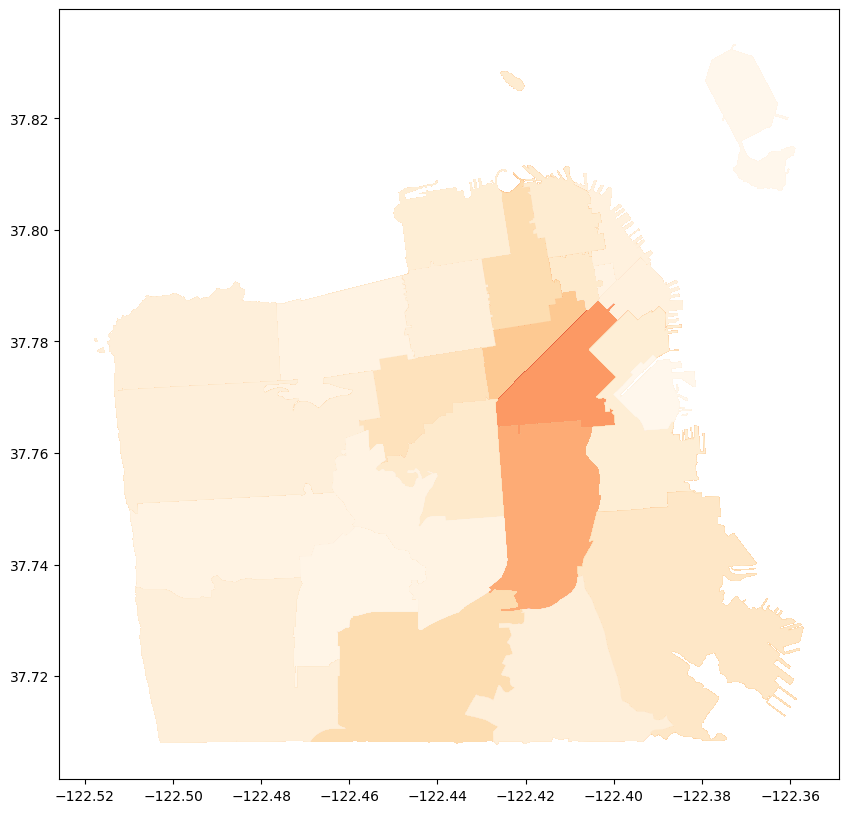

In [25]:
# Merge GeoDataFrames
choropleth_data = hour_totals_17.merge(right=sf)

# Convert merged GeoDataFrame with geometry and CRS
choropleth_data = gpd.GeoDataFrame(choropleth_data, geometry='geometry', crs='epsg:4326')

# Plot choropleth map
choropleth_data.plot(column='Crimes', cmap='OrRd', figsize=(13, 10))

This notebook is inspired by Orlando Torres' article, [Data Science gone wrong: Predictive Policing is a WMD](https://towardsdatascience.com/the-perils-of-predictive-policing-11928a9f1d60).